In [40]:
## METRIC : ACCURACY FOR THIS CHALLENGE
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime
#%matplotlib inline
import seaborn as sns
import warnings
sns.set()

The metric in the rules is the number of missclassified data points, so accuracy_score seems the most logical choice.

In [2]:
train=pd.read_csv('C:/Users/Amine/Desktop/Zindi_Competition/Train_Zindi.csv')
test=pd.read_csv('C:/Users/Amine/Desktop/Zindi_Competition/Test_Zindi.csv')
submission_file=pd.read_csv('C:/Users/Amine/Desktop/Zindi_Competition/SubmissionFile_Zindi.csv')
Variables=pd.read_csv('C:/Users/Amine/Desktop/Zindi_Competition/VariableDefinitions_Zindi.csv')

We will be predicting if a person has a bank account or not using variables given in datasets. So this is a binary classification problem, and the algorithms used here, and the metric are specific to this problem.

In [36]:
Variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


###### Descriptive statistics about our data

In [12]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


How the 5 first rows in the trainset look like!

In [14]:
train.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

No nulls. great!

In [15]:
train.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.681602,38.805220
std,0.847371,2.279956,16.520569
min,2016.000000,0.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


3 numerical columns only. Most of the columns are categorical.

In [31]:
train.dtypes

country                   object
year                       int64
uniqueid                  object
bank_account              object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
dtype: object

###### dataset balance?

Lets see if our dataset is balanced or not by checking our target distribution.

In [16]:
train.bank_account.value_counts()

No     20212
Yes     3312
Name: bank_account, dtype: int64

In [21]:
a = len(train[train.bank_account=='Yes'])
b = len(train[train.bank_account=='No'])
c = len(train)
print('We have an imbalanced dataset with a %i/%i ratio'%((b/c*100),(a/c*100)+1))

We have an imbalanced dataset with a 85/15 ratio


Stratification will be needed when doing cross-validation to preserve this ratio in our folds!

###### The id+country thing

In [33]:
train.uniqueid.value_counts().head(5)

uniqueid_1985    4
uniqueid_30      4
uniqueid_1020    4
uniqueid_491     4
uniqueid_1800    4
Name: uniqueid, dtype: int64

some uniqueid's have the same value 4 times. this can be explained by the number of countries in the dataset. Hence the need to identify people by 'country'+'uniqueid' to avoid having duplicate uniqueid values.

In [38]:
test.uniqueid.value_counts().head(5)

uniqueid_8620    3
uniqueid_8547    3
uniqueid_8585    3
uniqueid_8565    3
uniqueid_8664    3
Name: uniqueid, dtype: int64

Same thing needs to be done for the test set.

### Exploratory Data Analysis

Lets start one variable at a time, see the distribution, then plot it against the target!

#### Distributions

###### age_of_respondant

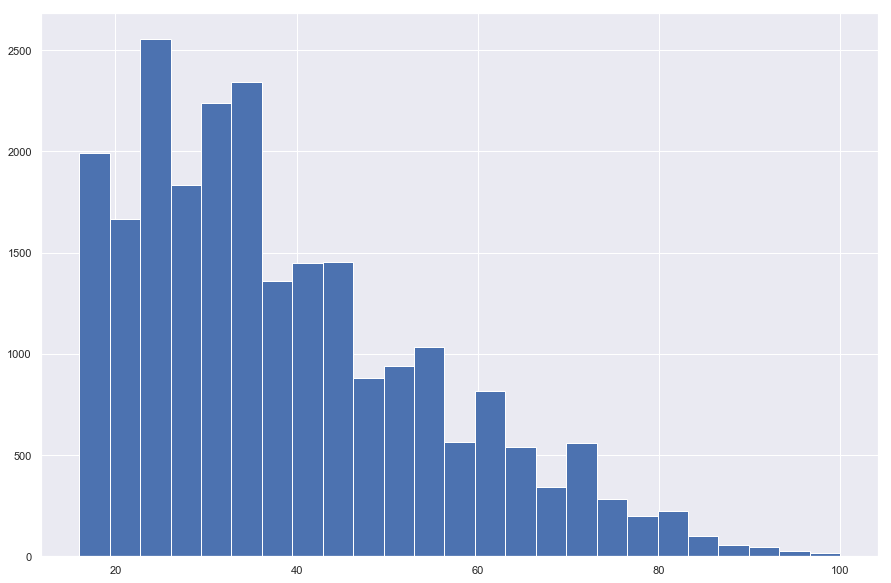

In [41]:
hist_age = train.age_of_respondent.hist(bins=25,figsize=[15,10])

We have a skewed to the right distribution for this variable. Lets try to make it look like a bit more Gaussian by applying x to log base 10 of x and sqrt

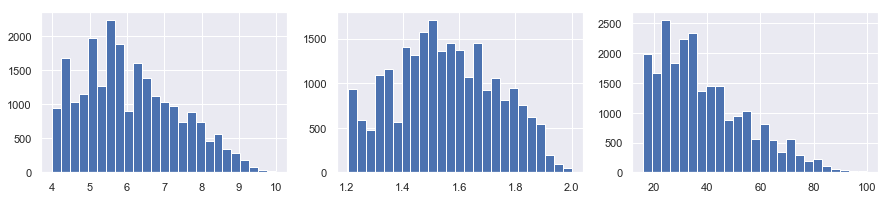

In [56]:
log_age = train.age_of_respondent.apply(np.log10)
root_age = train.age_of_respondent.apply(np.sqrt)
plt.subplot(331)
hist_sqrt_age = root_age.hist(bins=25,figsize=[15,10]) ## sqrt applied to age
plt.subplot(332)
hist_log_age = log_age.hist(bins=25,figsize=[15,10]) ## log10 applied to age
plt.subplot(333)
hist_age = train.age_of_respondent.hist(bins=25,figsize=[15,10]) ## original distribution

The middle distribution ( log10 ) looks the most normal. We can see on the far right histogram that the mean of age equal to 38 given by the describe() makes sense given this distribution.

###### country

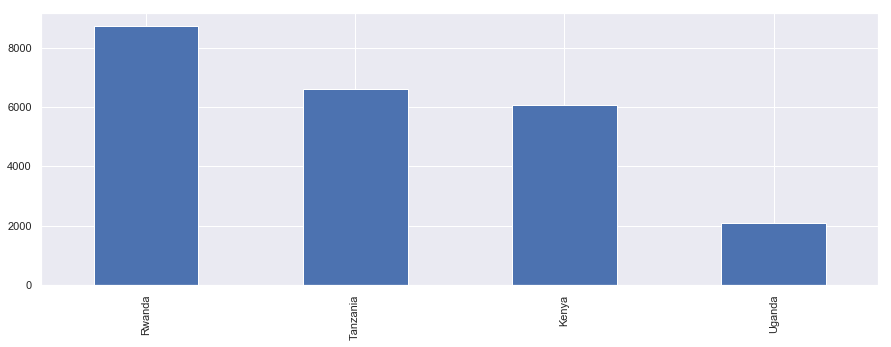

In [69]:
train['country'].value_counts().plot(kind='bar',figsize=[15,5])

Rwanda is the most occuring value for country, while Uganda is the least occuring one.

###### location type

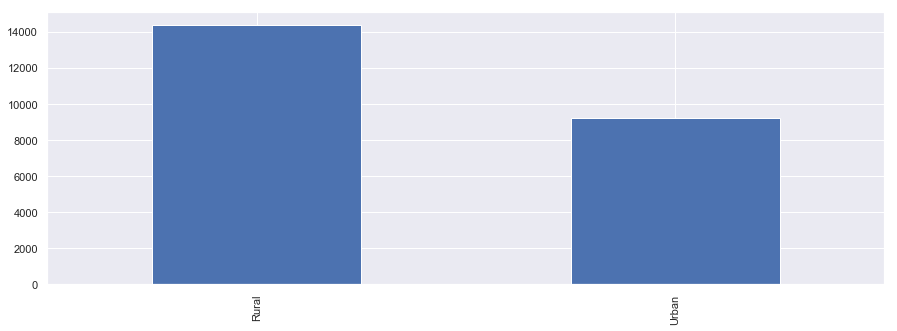

In [71]:
train['location_type'].value_counts().plot(kind='bar',figsize=[15,5])

More people from rural places have been interviewed than people in urban places.

###### cellphone access

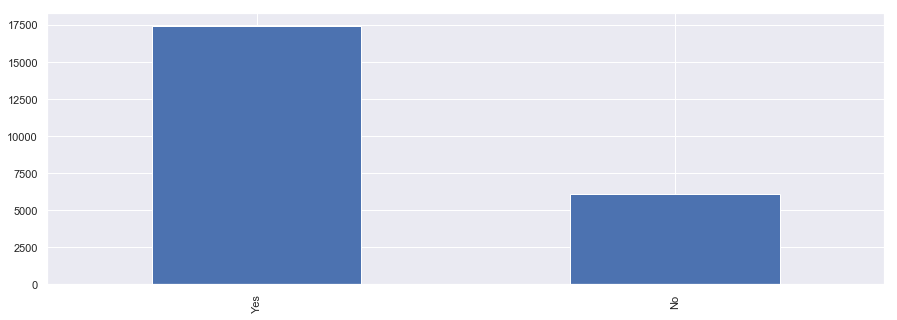

In [73]:
train['cellphone_access'].value_counts().plot(kind='bar',figsize=[15,5])

Looking at the data beforehand, one could guess that this variable would turn out to be a very good predictor, but looking at this distribution and the target distribution it seems not unless 'Yes' indicates the non-possession of a bank account which is unlikely.

###### household_size

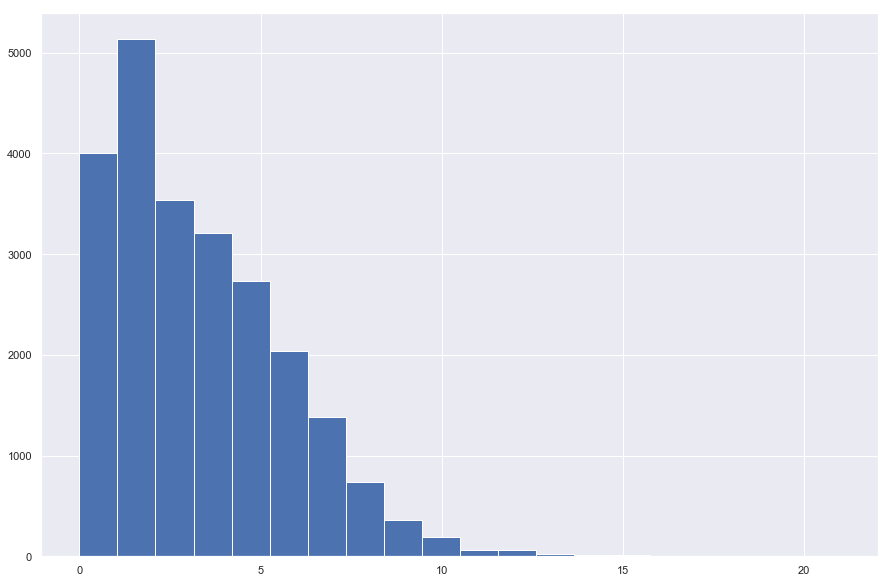

In [75]:
hist_hs = train.household_size.hist(bins=20,figsize=[15,10])

Another numerical distribution that's skewed to the right. Average would be around 3

###### gender of respondant

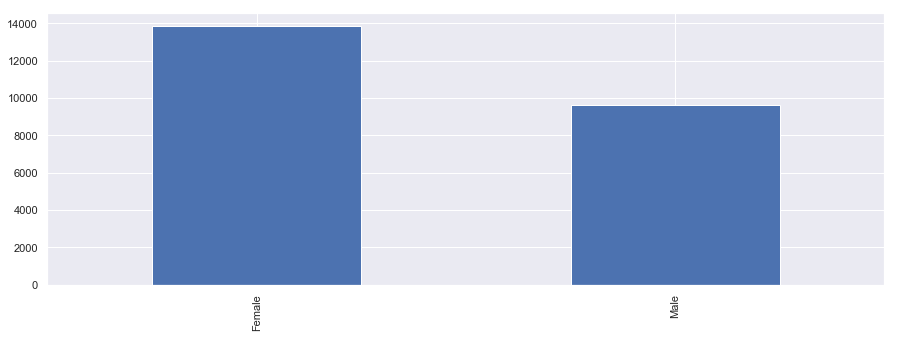

In [76]:
train['gender_of_respondent'].value_counts().plot(kind='bar',figsize=[15,5])

Trainset has more females than males.

###### relationship with head

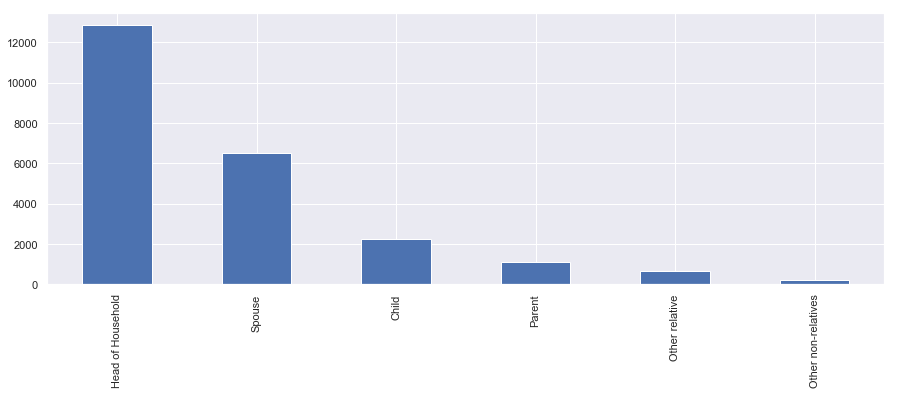

In [84]:
train['relationship_with_head'].value_counts().plot(kind='bar',figsize=[15,5])

This variable has 6 categories that are uneven in terms of distribution. The most occuring category is 'Head of Household' followed by Spouse. These two categories represent 70%+ of the trainset.

###### marital status

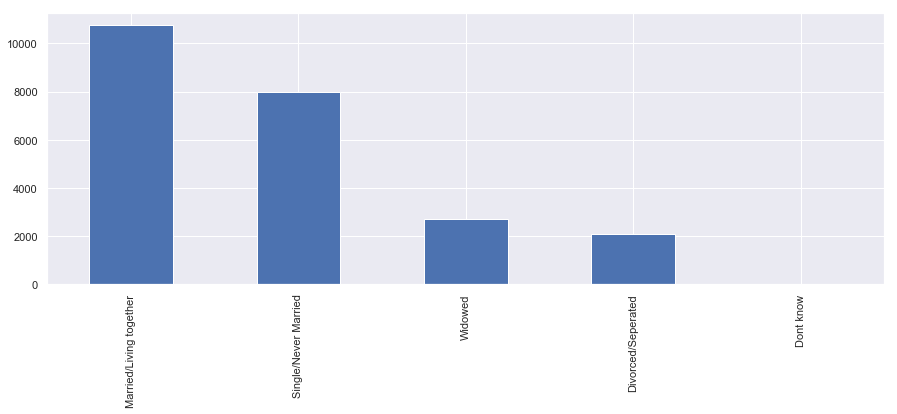

In [85]:
train['marital_status'].value_counts().plot(kind='bar',figsize=[15,5])

5 categories with one category 'Don't know' being significantly undersampled

###### education_level

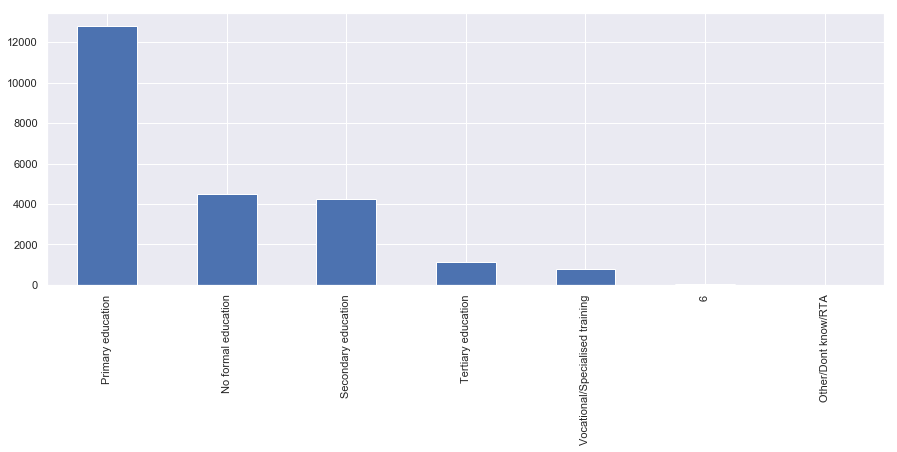

In [86]:
train['education_level'].value_counts().plot(kind='bar',figsize=[15,5])

7 categories, one category is called '6' and is undersampled; another category is 'Other/Dont know/RTA' is also undersampled

###### Job_type

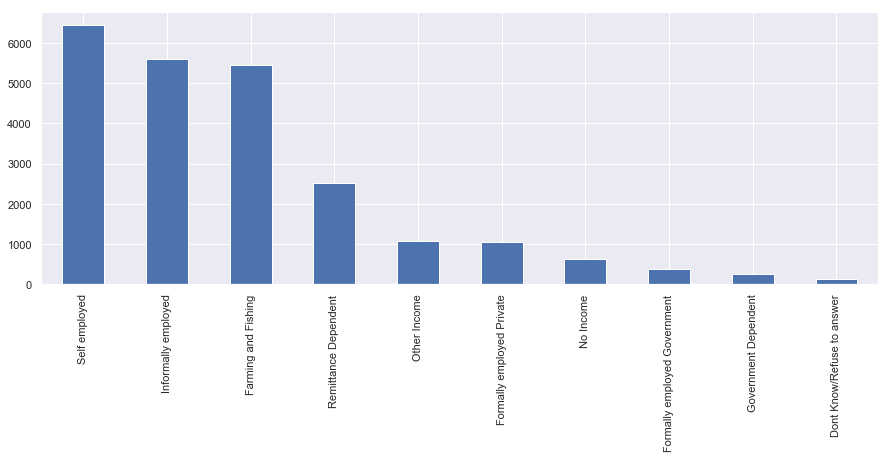

In [89]:
train['job_type'].value_counts().plot(kind='bar',figsize=[15,5])

We have a number of categories while 3 are dominant, the rest are close in terms of distribution.

#### Univariate Analysis and more ( using target value )